# Results

**Inputs:**
- results/perf_metrics.csv

**Outputs:**
- results/tables/
- results/figures/

## Setup and imports

In [27]:
try:
  from google.colab import userdata
  from google.colab import drive
  drive.mount('/content/drive')
  PROJECT_ROOT = userdata.get('PROJECT_ROOT')
except ImportError:
  PROJECT_ROOT = '/'

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import ttest_rel

sns.set_style('whitegrid')
sns.set_context('paper', font_scale=1)

## Function library

In [29]:
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from scipy.stats import sem, t

def get_perf_metrics(y_true, y_pred, y_pred_proba):
  '''
    Calculates the performance metrics for a given set of predictions.

    Inputs
      y_true: true labels
      y_pred: predicted labels
      y_pred_proba: predicted probabilities

    Outputs
      accuracy: accuracy score
      roc_auc: ROC AUC (Receiver Operating Characteristic Area Under the Curve)
      FNR: False Negative Rate
      FPR: False Positive Rate
      tn: True Negatives
      fp: False Positives
      fn: False Negatives
      tp: True Positives
  '''
  accuracy = accuracy_score(y_true, y_pred)
  roc_auc = roc_auc_score(y_true, y_pred_proba)
  tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
  FNR = fn / (fn + tp)
  FPR = fp / (fp + tn)

  return [accuracy, roc_auc, FNR, FPR, tn, fp, fn, tp]

def get_95_ci(data):
  '''
    Calculates the 95% confidence interval for a given set of data.

    Inputs
      data: data as a Pandas Series

    Outputs
      interval: Array of the lower and upper bounds of the confidence interval
  '''
  n = len(data)
  mean = data.mean()
  std_err = sem(data)
  interval = t.interval(0.95, n - 1, loc=mean, scale=std_err)
  return interval

In [30]:
perf_metrics = pd.read_csv(f'{PROJECT_ROOT}/results/perf_metrics_50_runs_2026-02-09_incl-sex.csv')

## Performance and group fairness

In [31]:
# BASELINE PERFORMANCE
accuracy_ci = get_95_ci(perf_metrics['accuracy'])
roc_auc_ci = get_95_ci(perf_metrics['roc_auc'])
fnr_ci = get_95_ci(perf_metrics['FNR'])
fpr_ci = get_95_ci(perf_metrics['FPR'])

# FAIR PERFORMANCE
fair_accuracy_ci = get_95_ci(perf_metrics['fair_accuracy'])
fair_roc_auc_ci = get_95_ci(perf_metrics['fair_roc_auc'])
fair_fnr_ci = get_95_ci(perf_metrics['fair_FNR'])
fair_fpr_ci = get_95_ci(perf_metrics['fair_FPR'])

perf_summary = pd.DataFrame({
    'Model': ['Baseline', 'Fair'],
    'Accuracy': [perf_metrics['accuracy'].mean(),
                 perf_metrics['fair_accuracy'].mean()],
    'Acc. 95% CI': [f'{round(accuracy_ci[0], 3)}-{round(accuracy_ci[1], 3)}',
                    f'{round(fair_accuracy_ci[0], 3)}-{round(fair_accuracy_ci[1], 3)}'],
    'ROC AUC': [perf_metrics['roc_auc'].mean(),
                perf_metrics['fair_roc_auc'].mean()],
    'ROC AUC 95% CI': [f'{round(roc_auc_ci[0], 3)}-{round(roc_auc_ci[1], 3)}',
                       f'{round(fair_roc_auc_ci[0], 3)}-{round(fair_roc_auc_ci[1], 3)}'],
    'FNR': [perf_metrics['FNR'].mean(),
             perf_metrics['fair_FNR'].mean()],
    'FNR 95% CI': [f'{round(fnr_ci[0], 3)}-{round(fnr_ci[1], 3)}',
                    f'{round(fair_fnr_ci[0], 3)}-{round(fair_fnr_ci[1], 3)}'],
    'FPR': [perf_metrics['FPR'].mean(),
             perf_metrics['fair_FPR'].mean()],
    'FPR 95% CI': [f'{round(fpr_ci[0], 3)}-{round(fpr_ci[1], 3)}',
                    f'{round(fair_fpr_ci[0], 3)}-{round(fair_fpr_ci[1], 3)}']
})

print(perf_summary.to_markdown(index=False, numalign="right"))

| Model    |   Accuracy | Acc. 95% CI   |   ROC AUC | ROC AUC 95% CI   |      FNR | FNR 95% CI   |      FPR | FPR 95% CI   |
|:---------|-----------:|:--------------|----------:|:-----------------|---------:|:-------------|---------:|:-------------|
| Baseline |   0.856786 | 0.851-0.862   |   0.92655 | 0.923-0.93       | 0.140935 | 0.132-0.15   | 0.145299 | 0.136-0.154  |
| Fair     |   0.809594 | 0.805-0.814   |  0.881641 | 0.878-0.885      | 0.202374 | 0.195-0.209  | 0.179462 | 0.172-0.186  |


In [32]:
# Statistical significance of the difference in FNR disparity
fnr_fair_ttest = ttest_rel(perf_metrics['fair_FNR_diff'],
                           perf_metrics['FNR_diff'],
                           alternative='greater')
print("FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS")
print(f"Average FNR Disparity in the baseline model:\
 {perf_metrics['FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the baseline model:\
 {perf_metrics['FNR_diff'].std()*100:.2f}%")
print('-'*20)
print(f"Average FNR Disparity in the fair model:\
 {perf_metrics['fair_FNR_diff'].mean()*100:.2f}%")
print(f"Std Dev FNR Disparity in the fair model:\
 {perf_metrics['fair_FNR_diff'].std()*100:.2f}%")
print('-'*20)
print(f"Paired T-Statistic (t): {fnr_fair_ttest.statistic:.4f}")
print(f"P-value: {fnr_fair_ttest.pvalue:.6f}")

FNR DISPARITY BETWEEN MALE AND FEMALE PATIENTS
Average FNR Disparity in the baseline model: -15.56%
Std Dev FNR Disparity in the baseline model: 13.65%
--------------------
Average FNR Disparity in the fair model: -32.47%
Std Dev FNR Disparity in the fair model: 12.08%
--------------------
Paired T-Statistic (t): -10.4198
P-value: 1.000000


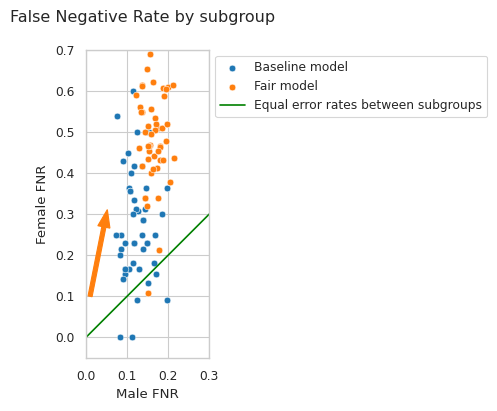

In [64]:
# Visualising difference in FNR disparity between baseline and fair model
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(4, 4))
sns.scatterplot(perf_metrics, x='FNR_m', y='FNR_f', ax=ax, c='#1f77b4')
sns.scatterplot(perf_metrics, x='fair_FNR_m', y='fair_FNR_f', ax=ax, c='#ff7f0e')
plt.plot([0,.7],[0,.7],c='g')

vx = (perf_metrics['fair_FNR_m'] - perf_metrics['FNR_m']).sum(axis=0) / perf_metrics.shape[0]
vy = (perf_metrics['fair_FNR_f'] - perf_metrics['FNR_f']).sum(axis=0) / perf_metrics.shape[0]
average_diff = mpatches.Arrow(0.01, 0.1, vx, vy, width=0.05, color="#ff7f0e" )
ax.add_patch(average_diff)

fig.suptitle('False Negative Rate by subgroup')
plt.xlabel('Male FNR')
plt.ylabel('Female FNR')
plt.legend(labels=['Baseline model', 'Fair model', 'Equal error rates between subgroups'], loc='upper left', bbox_to_anchor=(1, 1))
ax.set_xlim([0,0.3])
ax.set_ylim([-.05,0.7])
ax.set_aspect('equal')
plt.show()

## Counterfactual fairness

In [34]:
flipped_pos_m_ci = get_95_ci(perf_metrics['flipped_pos_m'])
flipped_neg_m_ci = get_95_ci(perf_metrics['flipped_neg_m'])
flipped_pos_f_ci = get_95_ci(perf_metrics['flipped_pos_f'])
flipped_neg_f_ci = get_95_ci(perf_metrics['flipped_neg_f'])

cf_fairness_summary = pd.DataFrame({
    'Original sex':['Male', 'Female'],
    '% flipped from y=0 to y=1':
     [f'{perf_metrics['flipped_pos_m'].mean()*100:.2f} [{flipped_pos_m_ci[0]*100:.2f} - {flipped_pos_m_ci[1]*100:.2f}]',
     f'{perf_metrics['flipped_pos_f'].mean()*100:.2f} [{flipped_pos_f_ci[0]*100:.2f} - {flipped_pos_f_ci[1]*100:.2f}]'],
    '% flipped from y=1 to y=0':
     [f'{perf_metrics['flipped_neg_m'].mean()*100:.2f} [{flipped_neg_m_ci[0]*100:.2f} - {flipped_neg_m_ci[1]*100:.2f}]',
     f'{perf_metrics['flipped_neg_f'].mean()*100:.2f} [{flipped_neg_f_ci[0]*100:.2f} - {flipped_neg_f_ci[1]*100:.2f}]']
})
print('\n--- COUNTERFACTUAL FAIRNESS of BASELINE MODEL ---')
print(cf_fairness_summary.to_markdown(index=False, numalign="right"))


--- COUNTERFACTUAL FAIRNESS of BASELINE MODEL ---
| Original sex   | % flipped from y=0 to y=1   | % flipped from y=1 to y=0   |
|:---------------|:----------------------------|:----------------------------|
| Male           | 0.72 [0.48 - 0.96]          | 13.75 [12.30 - 15.20]       |
| Female         | 13.30 [12.08 - 14.51]       | 0.21 [-0.05 - 0.48]         |
